# Estimating archaic TMRCAs from the real data

In [1]:
library(tidyverse)
library(magrittr)
library(here)
library(future)
library(bdkn)

plan(multiprocess)

devtools::load_all(".")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.3.0
✔ tibble  2.0.1     ✔ dplyr   0.7.8
✔ tidyr   0.8.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract

here() starts at /mnt/expressions/mp/ychr
Warning message:
“package ‘bdkn’ was built under R version 3.5.2”
Attaching package: ‘bdkn’

The following object is masked from ‘package:ggplot2’:

    %+%

Loading ychr


In [2]:
tmrca_full    %<-% calculate_tmrca(read_gt(here("data/vcf/merged_full.vcf.gz")))
tmrca_full_tv %<-% calculate_tmrca(read_gt(here("data/vcf/merged_full.vcf.gz"), tv_only = TRUE))
tmrca_lippold %<-% calculate_tmrca(read_gt(here("data/vcf/merged_lippold.vcf.gz")))
tmrca_exome   %<-% calculate_tmrca(read_gt(here("data/vcf/merged_exome.vcf.gz")))

In [3]:
tmrca_full %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,660326.1,7.828917,103344.8,107758.2,98931.44,7.273212e-10,NA
mez2,360849.3,4.242120,103344.8,107758.2,98931.44,7.273212e-10,NA
neand,347093.4,4.069019,103344.8,107758.2,98931.44,7.273212e-10,NA
spy1,308627.3,3.547616,103344.8,107758.2,98931.44,7.273212e-10,NA


In [4]:
tmrca_full_tv %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,677576.4,7.843930,107082.3,114025.5,100139.1,4.861232e-10,NA
mez2,378365.2,4.373584,107082.3,114025.5,100139.1,4.861232e-10,NA
neand,350470.4,4.015502,107082.3,114025.5,100139.1,4.861232e-10,NA
spy1,309974.2,3.536069,107082.3,114025.5,100139.1,4.861232e-10,NA


In [5]:
tmrca_lippold %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,378333.0,3.717857,104349.7,107732.7,100966.7,1.676082e-09,NA
elsidron2,253356.1,2.478815,104349.7,107732.7,100966.7,1.676082e-09,NA
neand,229982.9,2.255095,104349.7,107732.7,100966.7,1.676082e-09,NA


In [6]:
tmrca_exome %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,701979.1,7.956009,97836.19,94039.72,101632.7,9.209203e-10,NA
elsidron1,350660.6,4.121954,97836.19,94039.72,101632.7,9.209203e-10,NA
neand,Inf,Inf,97836.19,94039.72,101632.7,9.209203e-10,NA


In [3]:
tmrca_full %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,643847.0,7.658384,102433.5,106818.7,98048.32,7.275693e-10,NA
mez2,354969.8,4.188505,102433.5,106818.7,98048.32,7.275693e-10,NA
neand,339775.8,3.999934,102433.5,106818.7,98048.32,7.275693e-10,NA
spy1,301858.0,3.490244,102433.5,106818.7,98048.32,7.275693e-10,NA


In [4]:
tmrca_full_tv %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,658412.0,7.637777,106271.7,112930.2,99613.19,4.854902e-10,NA
mez2,372905.8,4.316872,106271.7,112930.2,99613.19,4.854902e-10,NA
neand,343067.6,3.940613,106271.7,112930.2,99613.19,4.854902e-10,NA
spy1,301519.0,3.442238,106271.7,112930.2,99613.19,4.854902e-10,NA


In [5]:
tmrca_lippold %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,380430.3,3.659196,106099.5,109814.7,102384.2,1.639098e-09,NA
elsidron2,258975.0,2.486672,106099.5,109814.7,102384.2,1.639098e-09,NA
neand,233209.5,2.247160,106099.5,109814.7,102384.2,1.639098e-09,NA


In [6]:
tmrca_exome %>% group_by(arch) %>% summarise_if(is.numeric, mean)

arch,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez
den8,630602.0,6.678709,102983.4,102108.2,103858.6,8.839004e-10,NA
elsidron1,359870.7,3.915499,102983.4,102108.2,103858.6,8.839004e-10,NA
neand,Inf,Inf,102983.4,102108.2,103858.6,8.839004e-10,NA


In [7]:
tmrca <- bind_rows(
    mutate(tmrca_full, set = "full"),
    mutate(tmrca_full_tv, set = "full_tv"),
    mutate(tmrca_lippold, set = "lippold"),
    mutate(tmrca_exome, set = "exome")
)

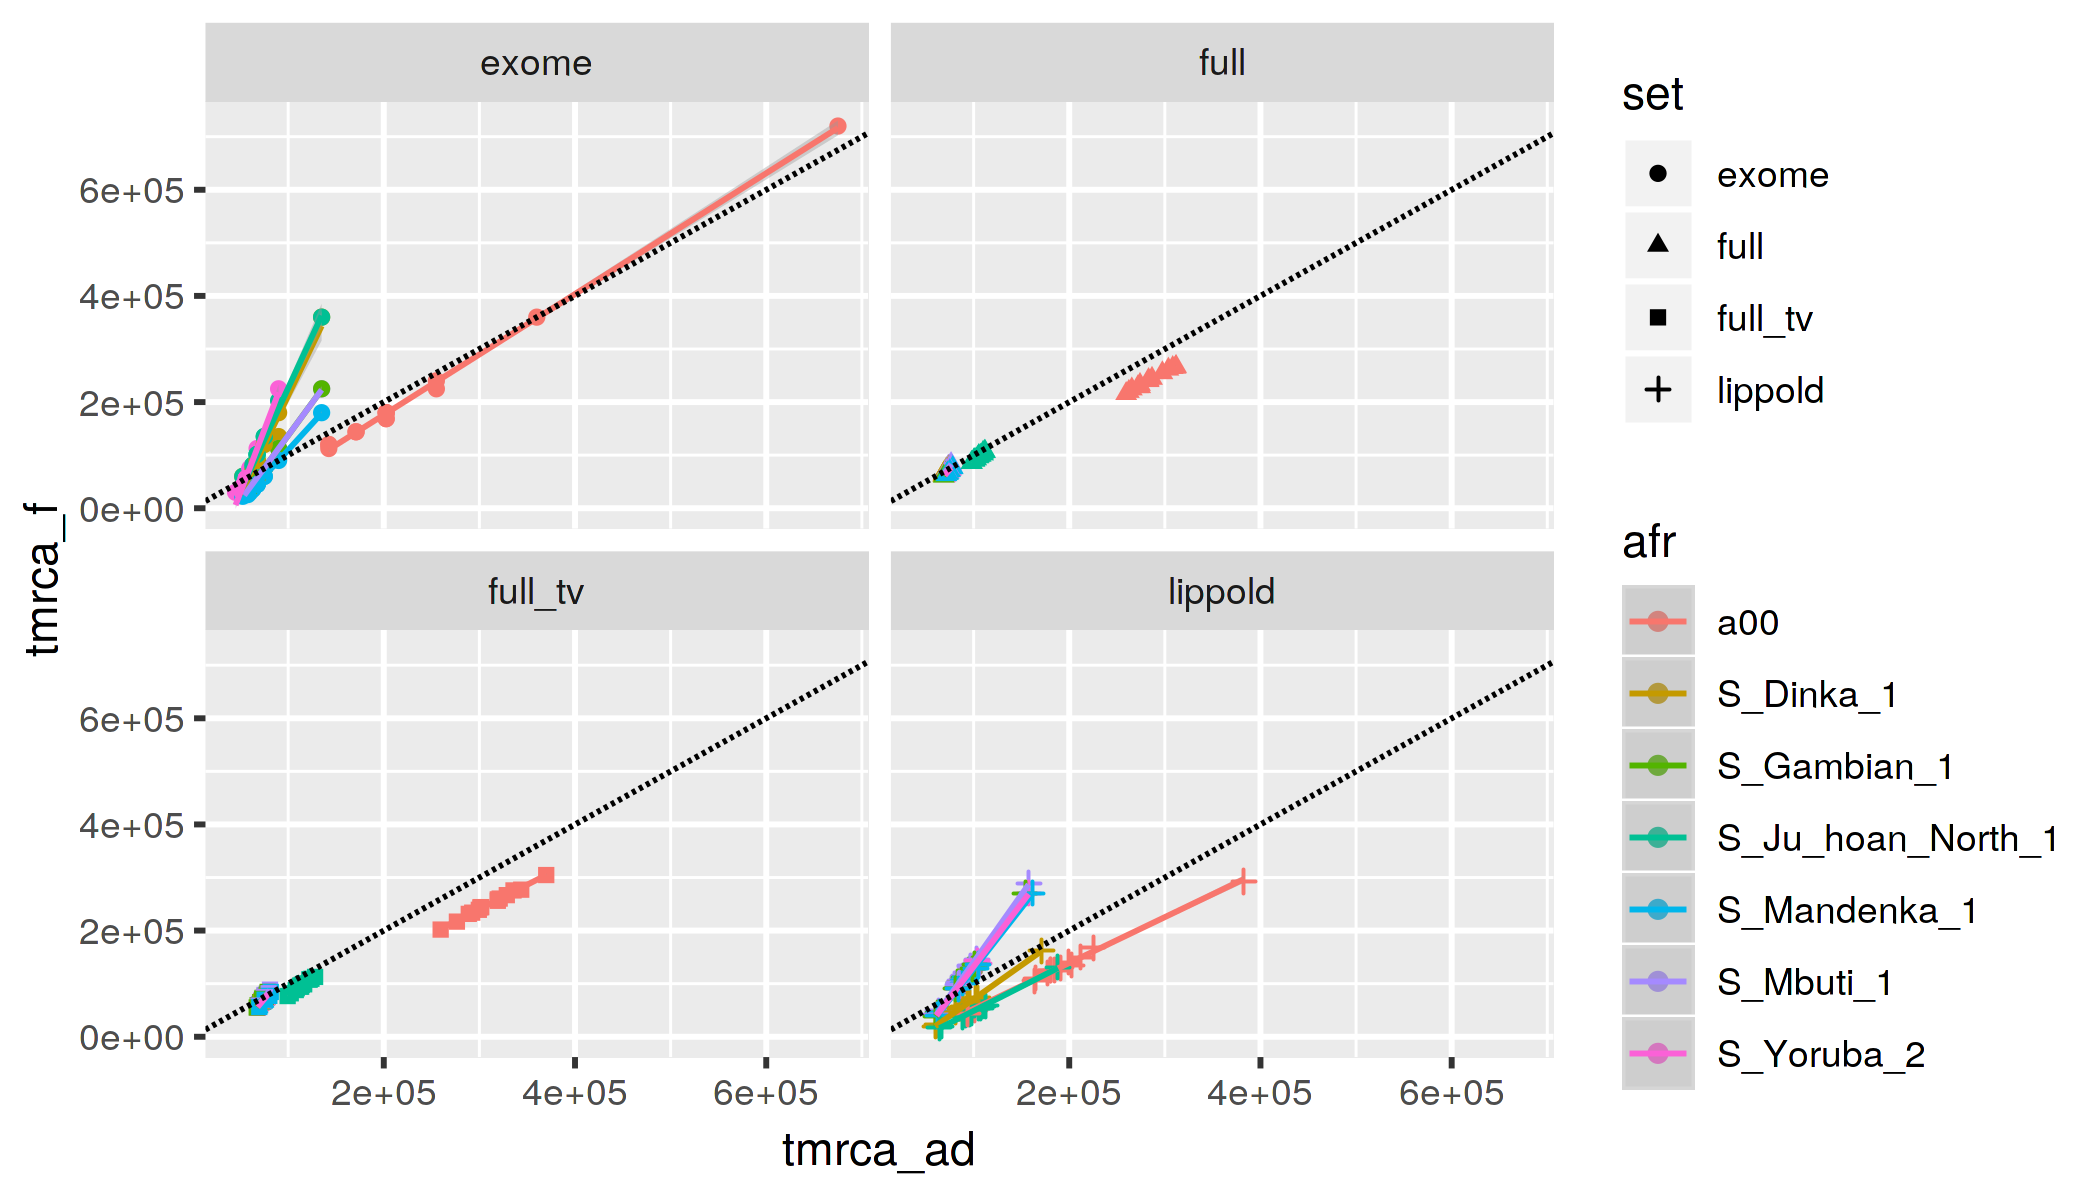

In [8]:
set_dim(7, 4)

filter(tmrca, arch == "den8") %>%
ggplot(aes(tmrca_ad, tmrca_f, color = afr, shape = set)) +
    geom_point() +
    geom_smooth(method = "lm", size = 0.5) +
    geom_abline(slope = 1, linetype = 2) +
    facet_wrap(~ set)

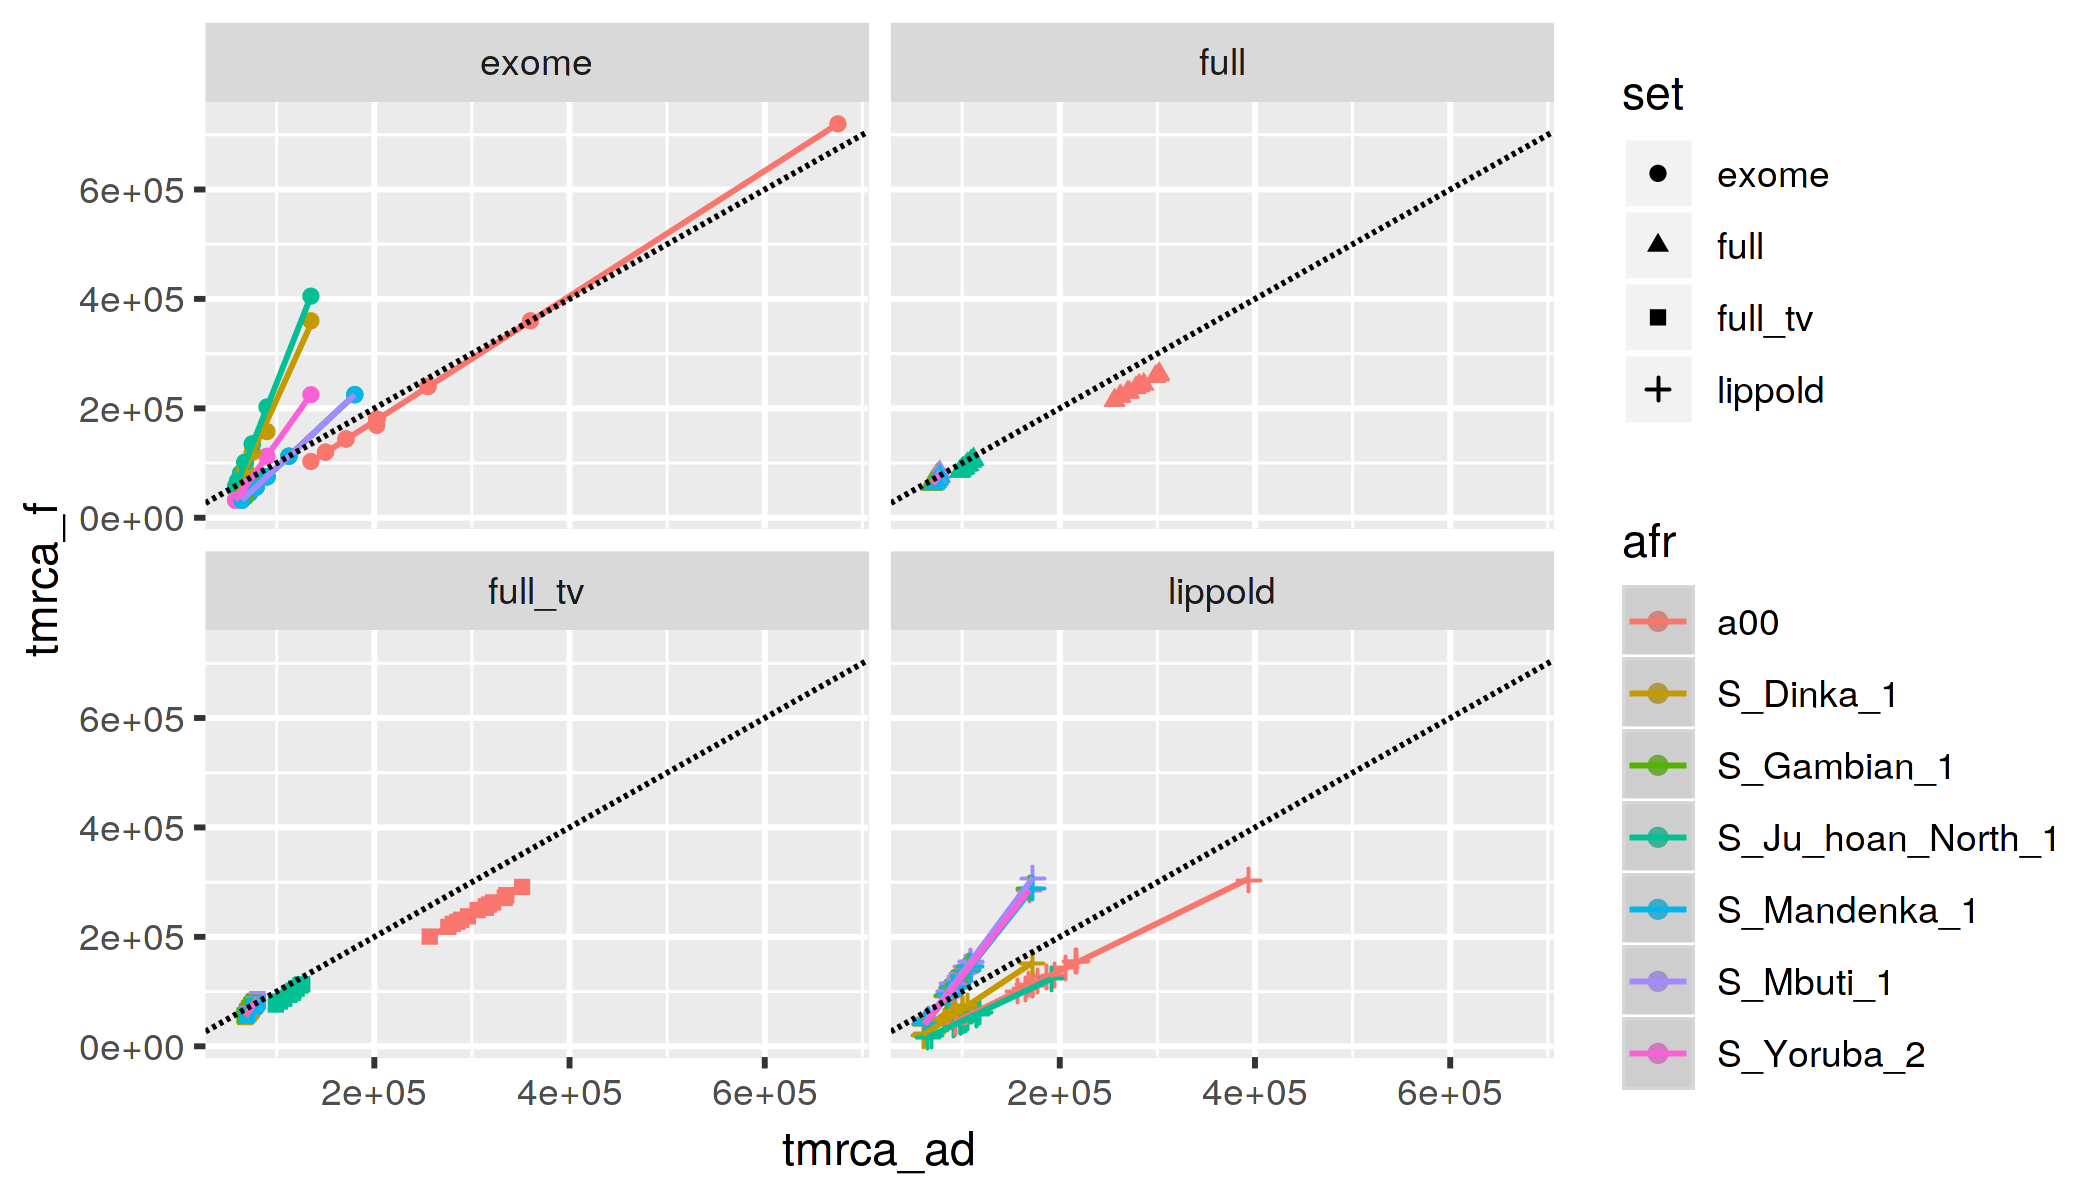

In [8]:
set_dim(7, 4)

filter(tmrca, arch == "den8") %>%
ggplot(aes(tmrca_ad, tmrca_f, color = afr, shape = set)) +
    geom_point() +
    geom_smooth(method = "lm", size = 0.5) +
    geom_abline(slope = 1, linetype = 2) +
    facet_wrap(~ set)

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?

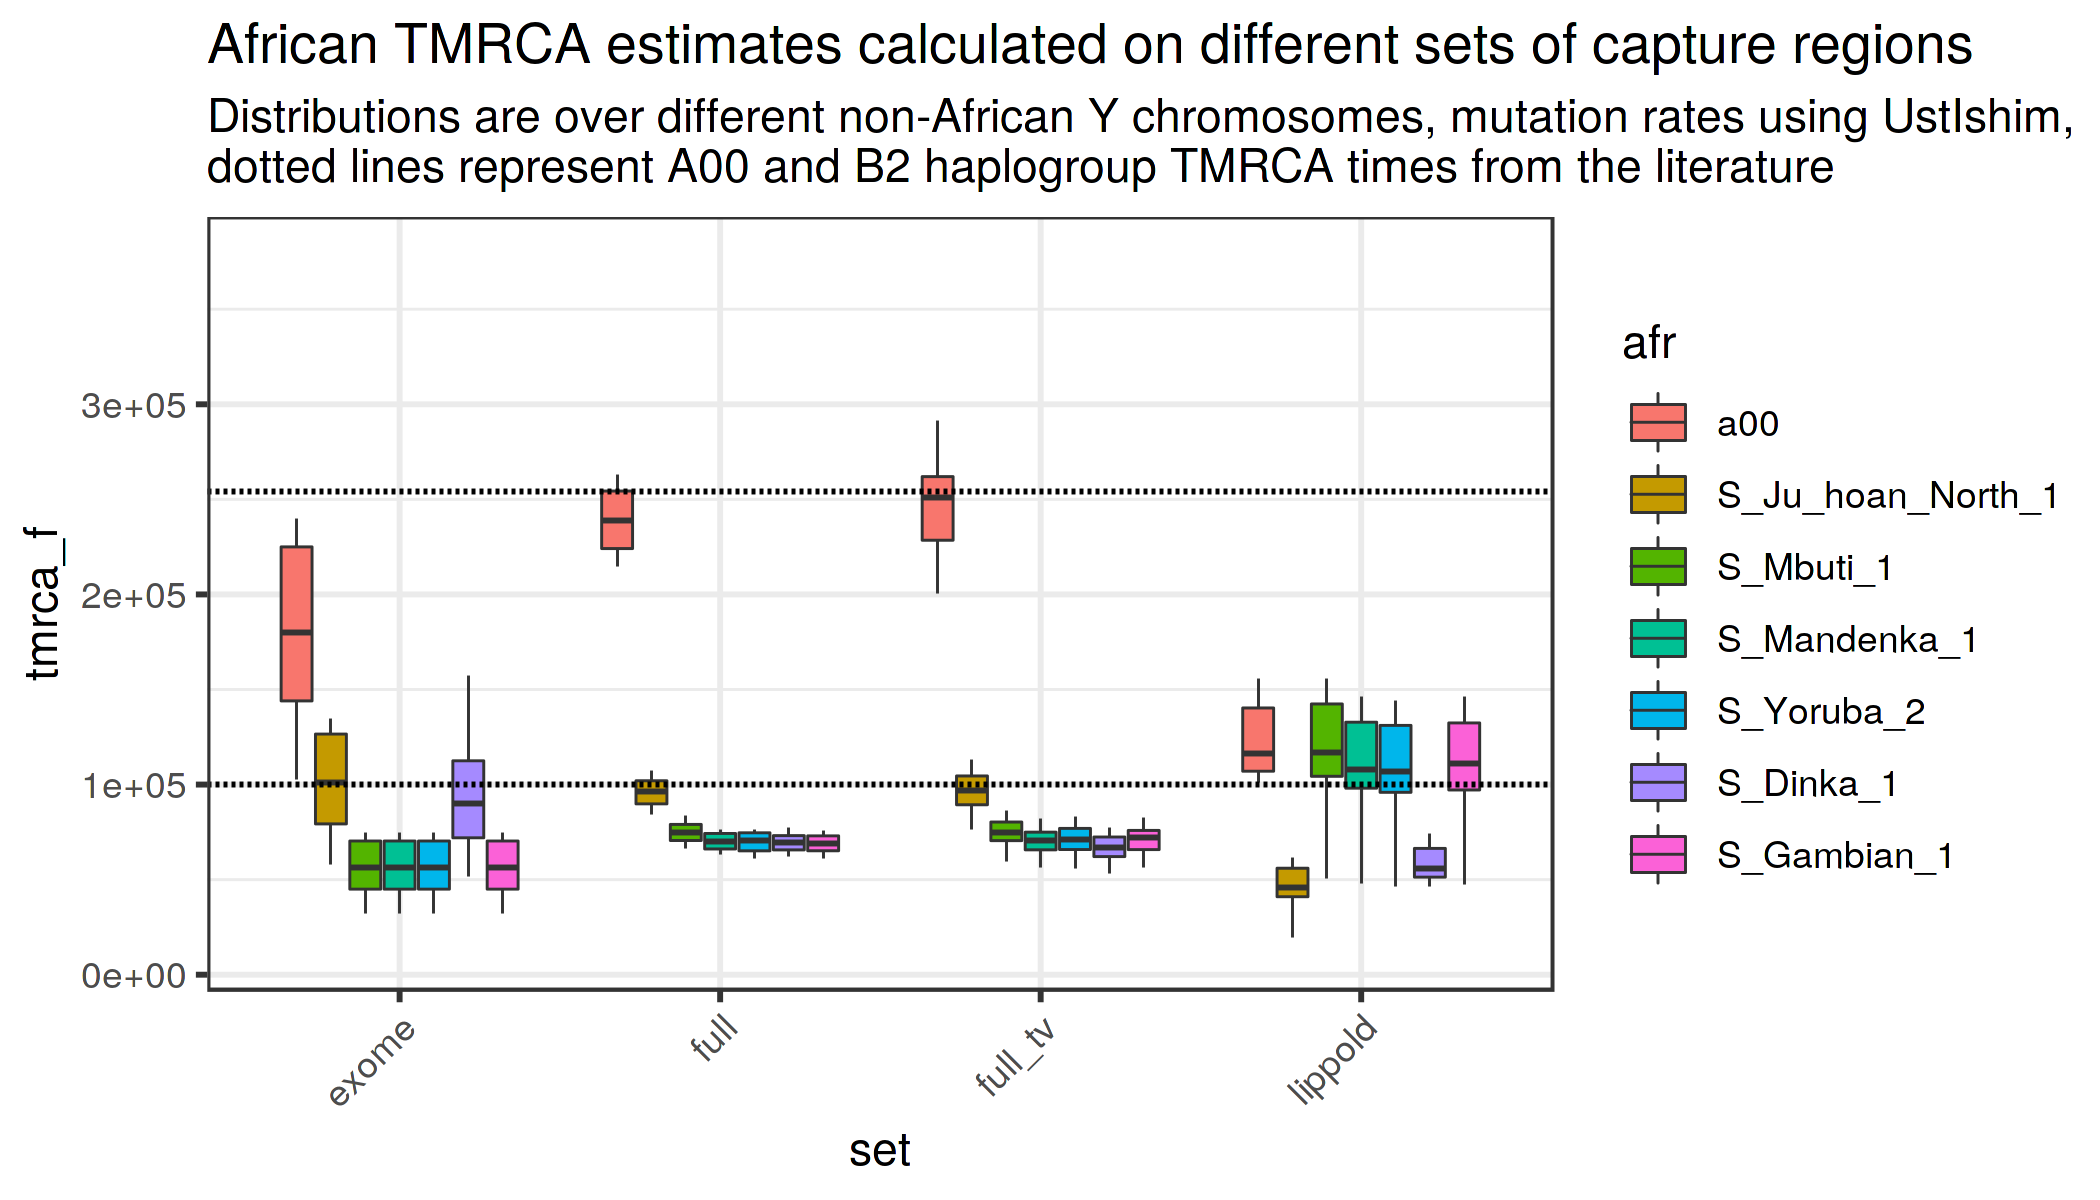

In [275]:
set_dim(7, 4)

tmrca %>% filter(arch == "den8") %>% 
ggplot(aes(set, tmrca_f, fill = fct_reorder(afr, tmrca_afr, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    coord_cartesian(y = c(10000, 380000)) +
    geom_hline(yintercept = c(254000, 100000), linetype = 2, size = 0.5) +
    guides(fill = guide_legend("afr")) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("African TMRCA estimates calculated on different sets of capture regions",
            "Distributions are over different non-African Y chromosomes, mutation rates using UstIshim,
dotted lines represent A00 and B2 haplogroup TMRCA times from the literature")

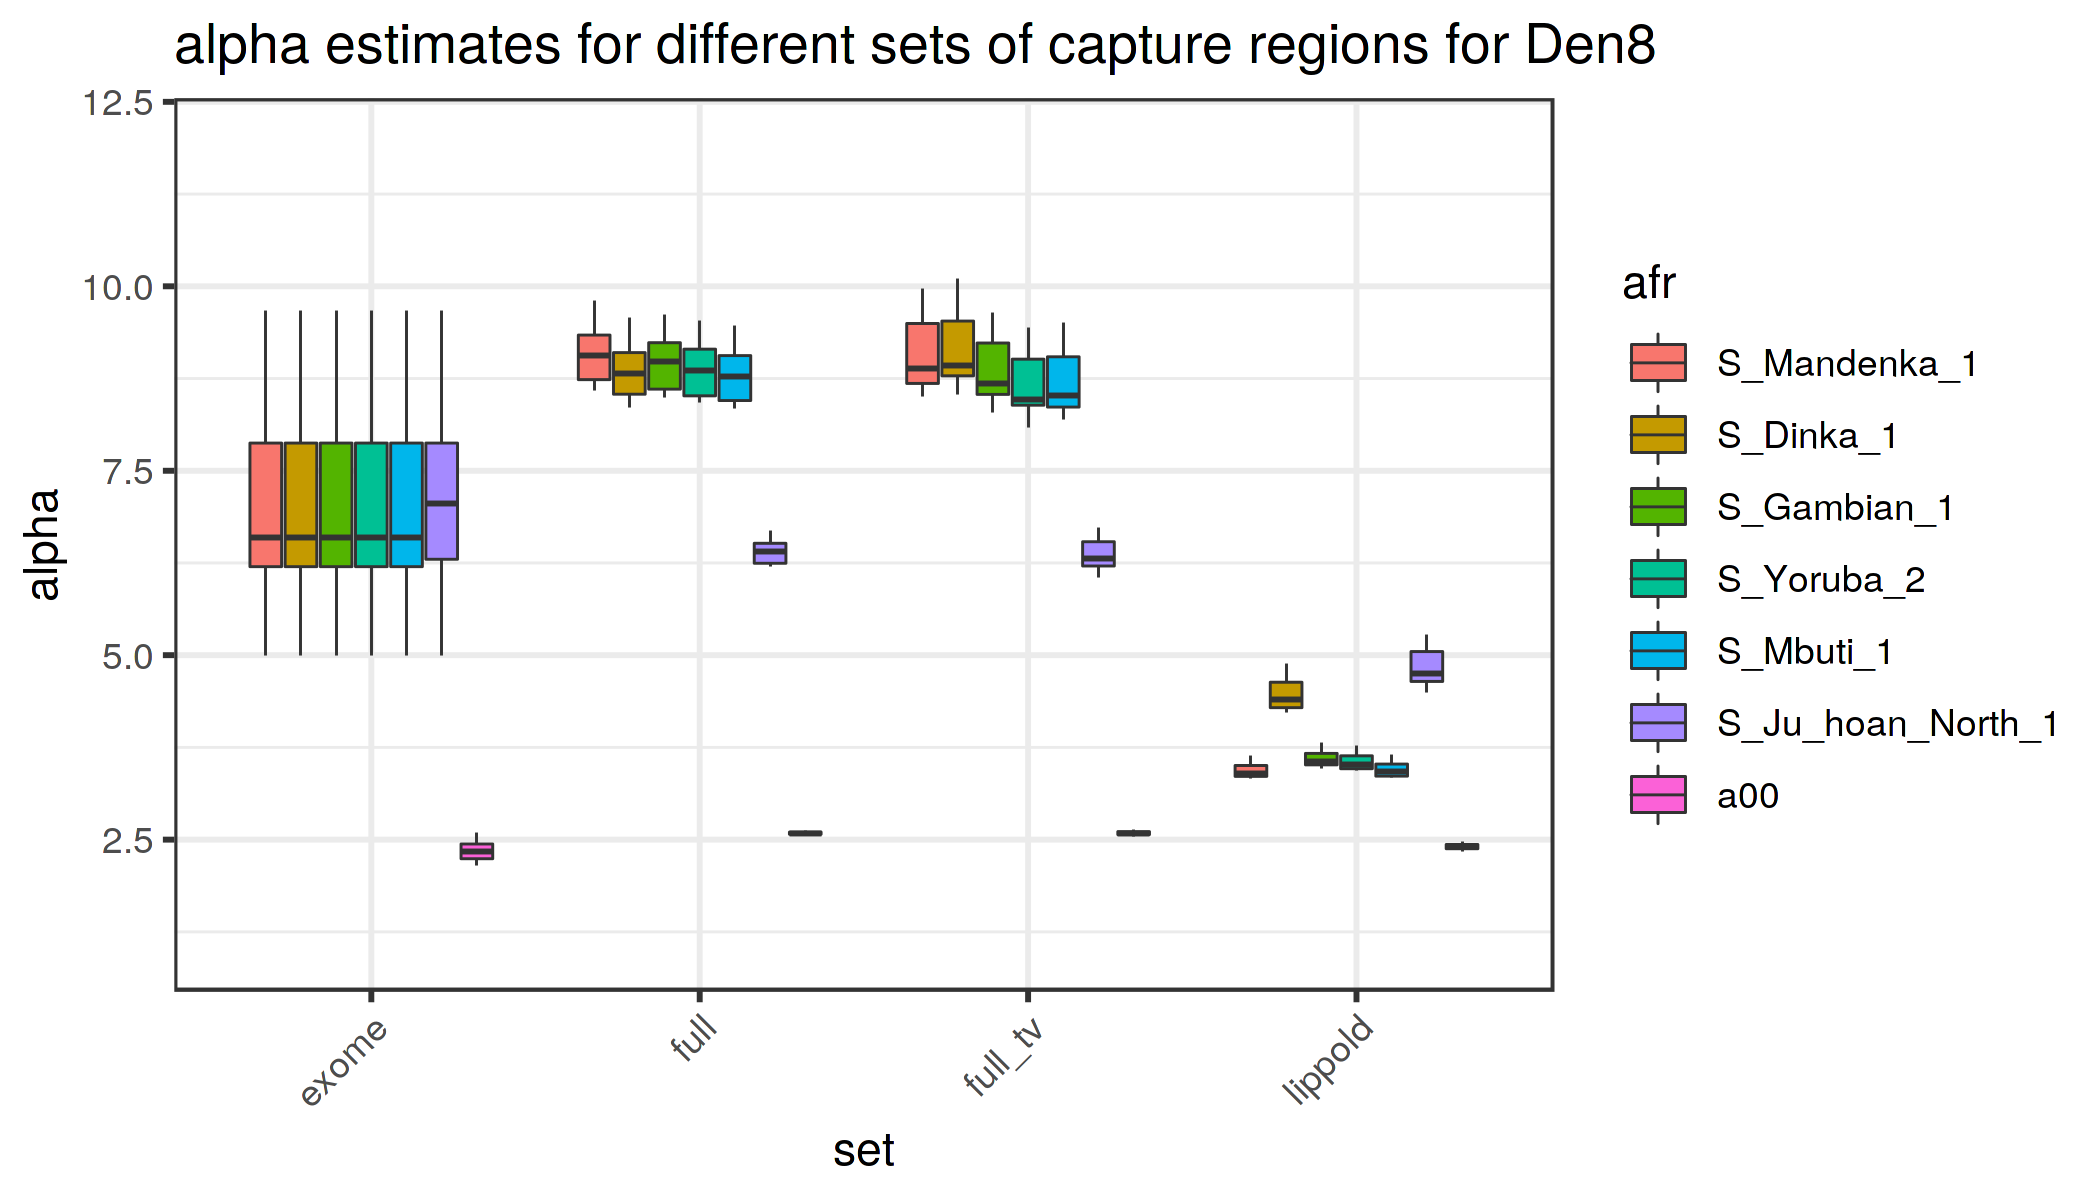

In [296]:
set_dim(7, 4)

tmrca %>% filter(arch == "den8") %>% 
ggplot(aes(set, alpha, fill = fct_reorder(afr, alpha, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    guides(fill = guide_legend("afr")) +
    coord_cartesian(y = c(1, 12)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("alpha estimates for different sets of capture regions for Den8")

Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”

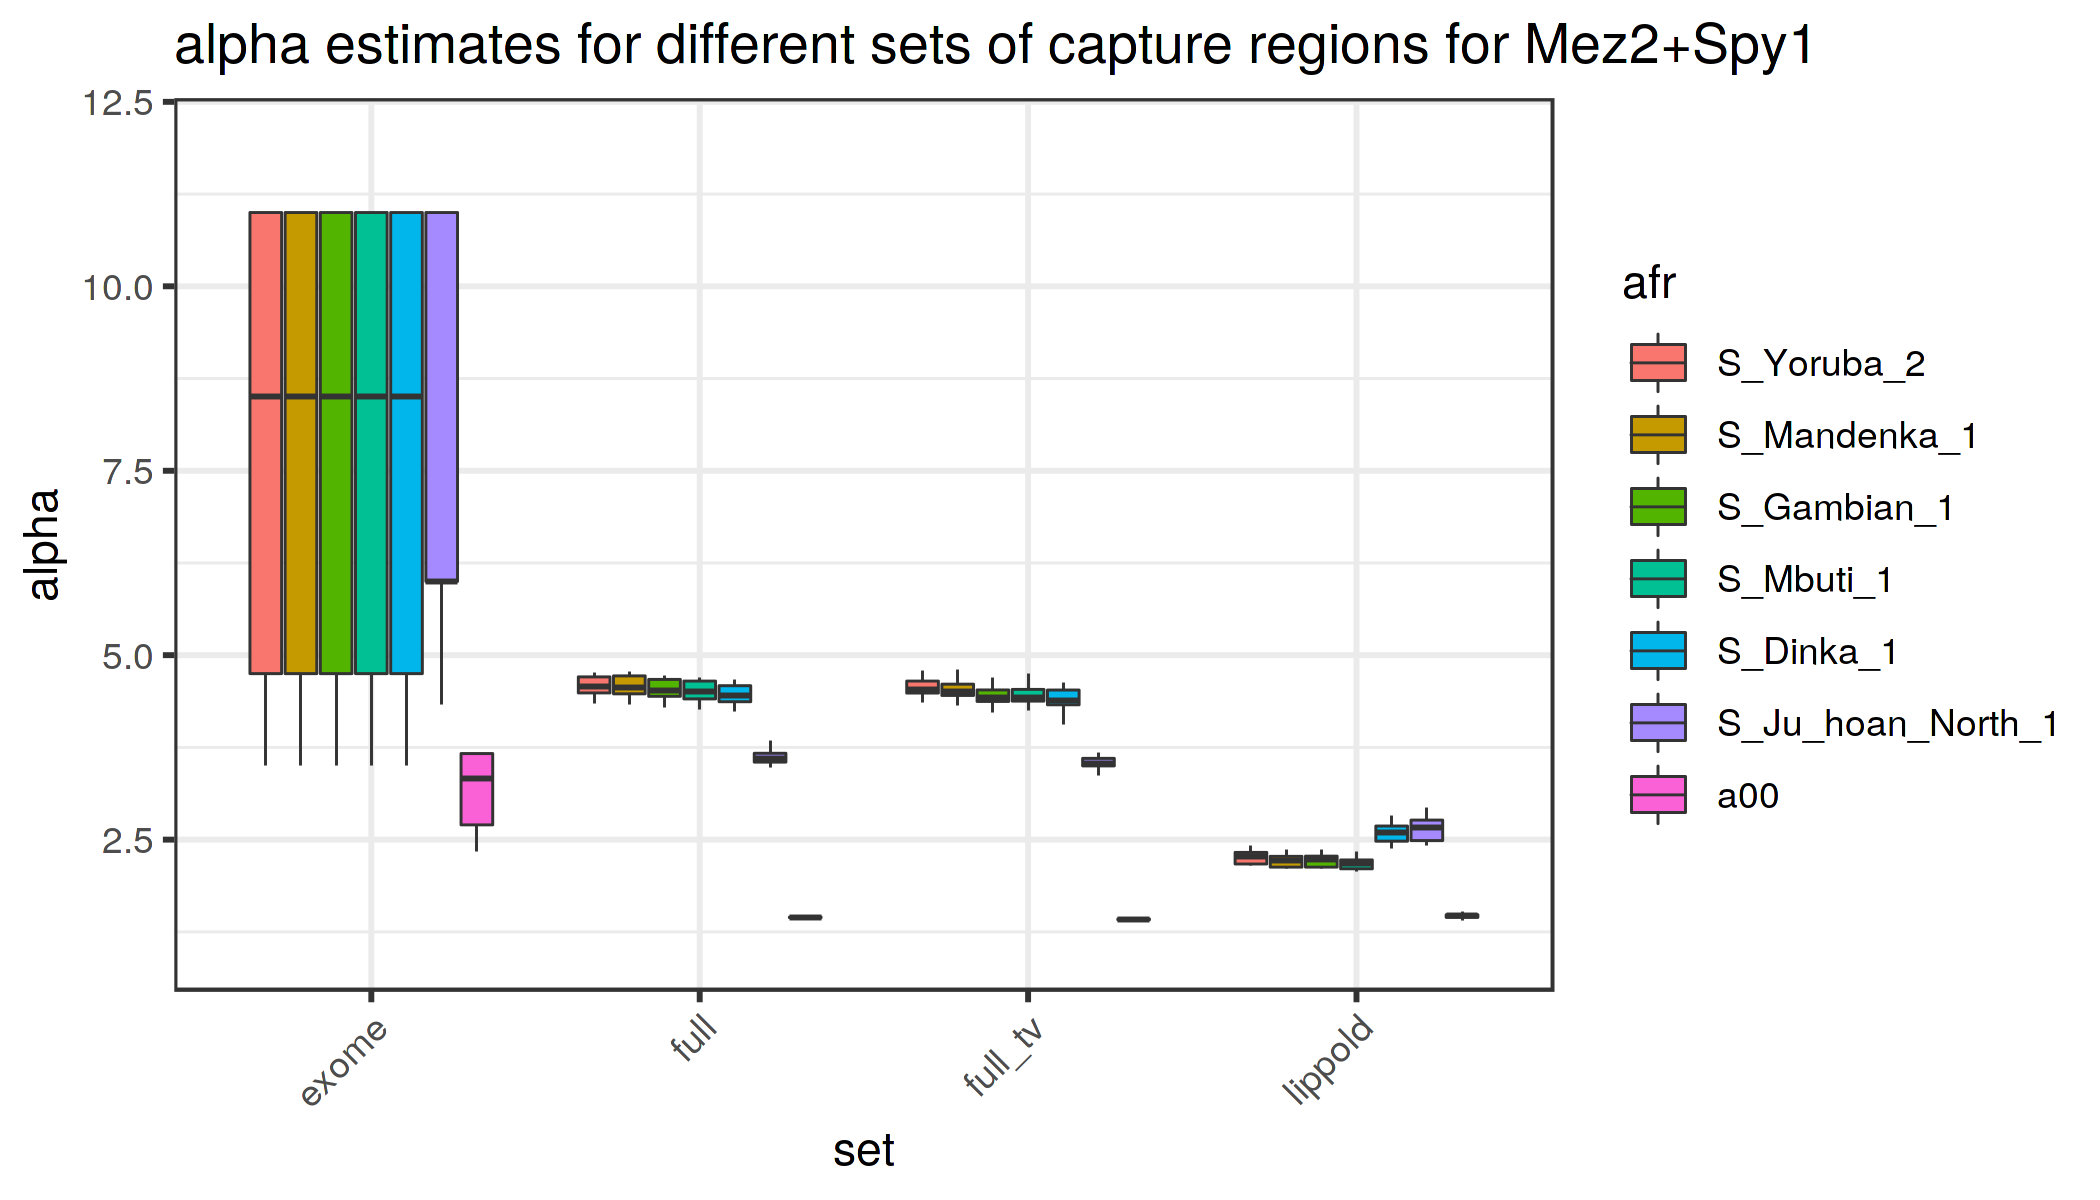

In [298]:
set_dim(7, 4)

tmrca %>% filter(arch == "neand") %>% 
ggplot(aes(set, alpha, fill = fct_reorder(afr, alpha, .desc = TRUE))) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    guides(fill = guide_legend("afr")) +
    coord_cartesian(y = c(1, 12)) +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("alpha estimates for different sets of capture regions for Mez2+Spy1")

$\alpha$ values stable across capture sets for A00, for Denisovans and Neanderthals.

Much lower $\alpha$ values for exome and Lippold regions.

Warning message:
“Removed 7 rows containing non-finite values (stat_boxplot).”

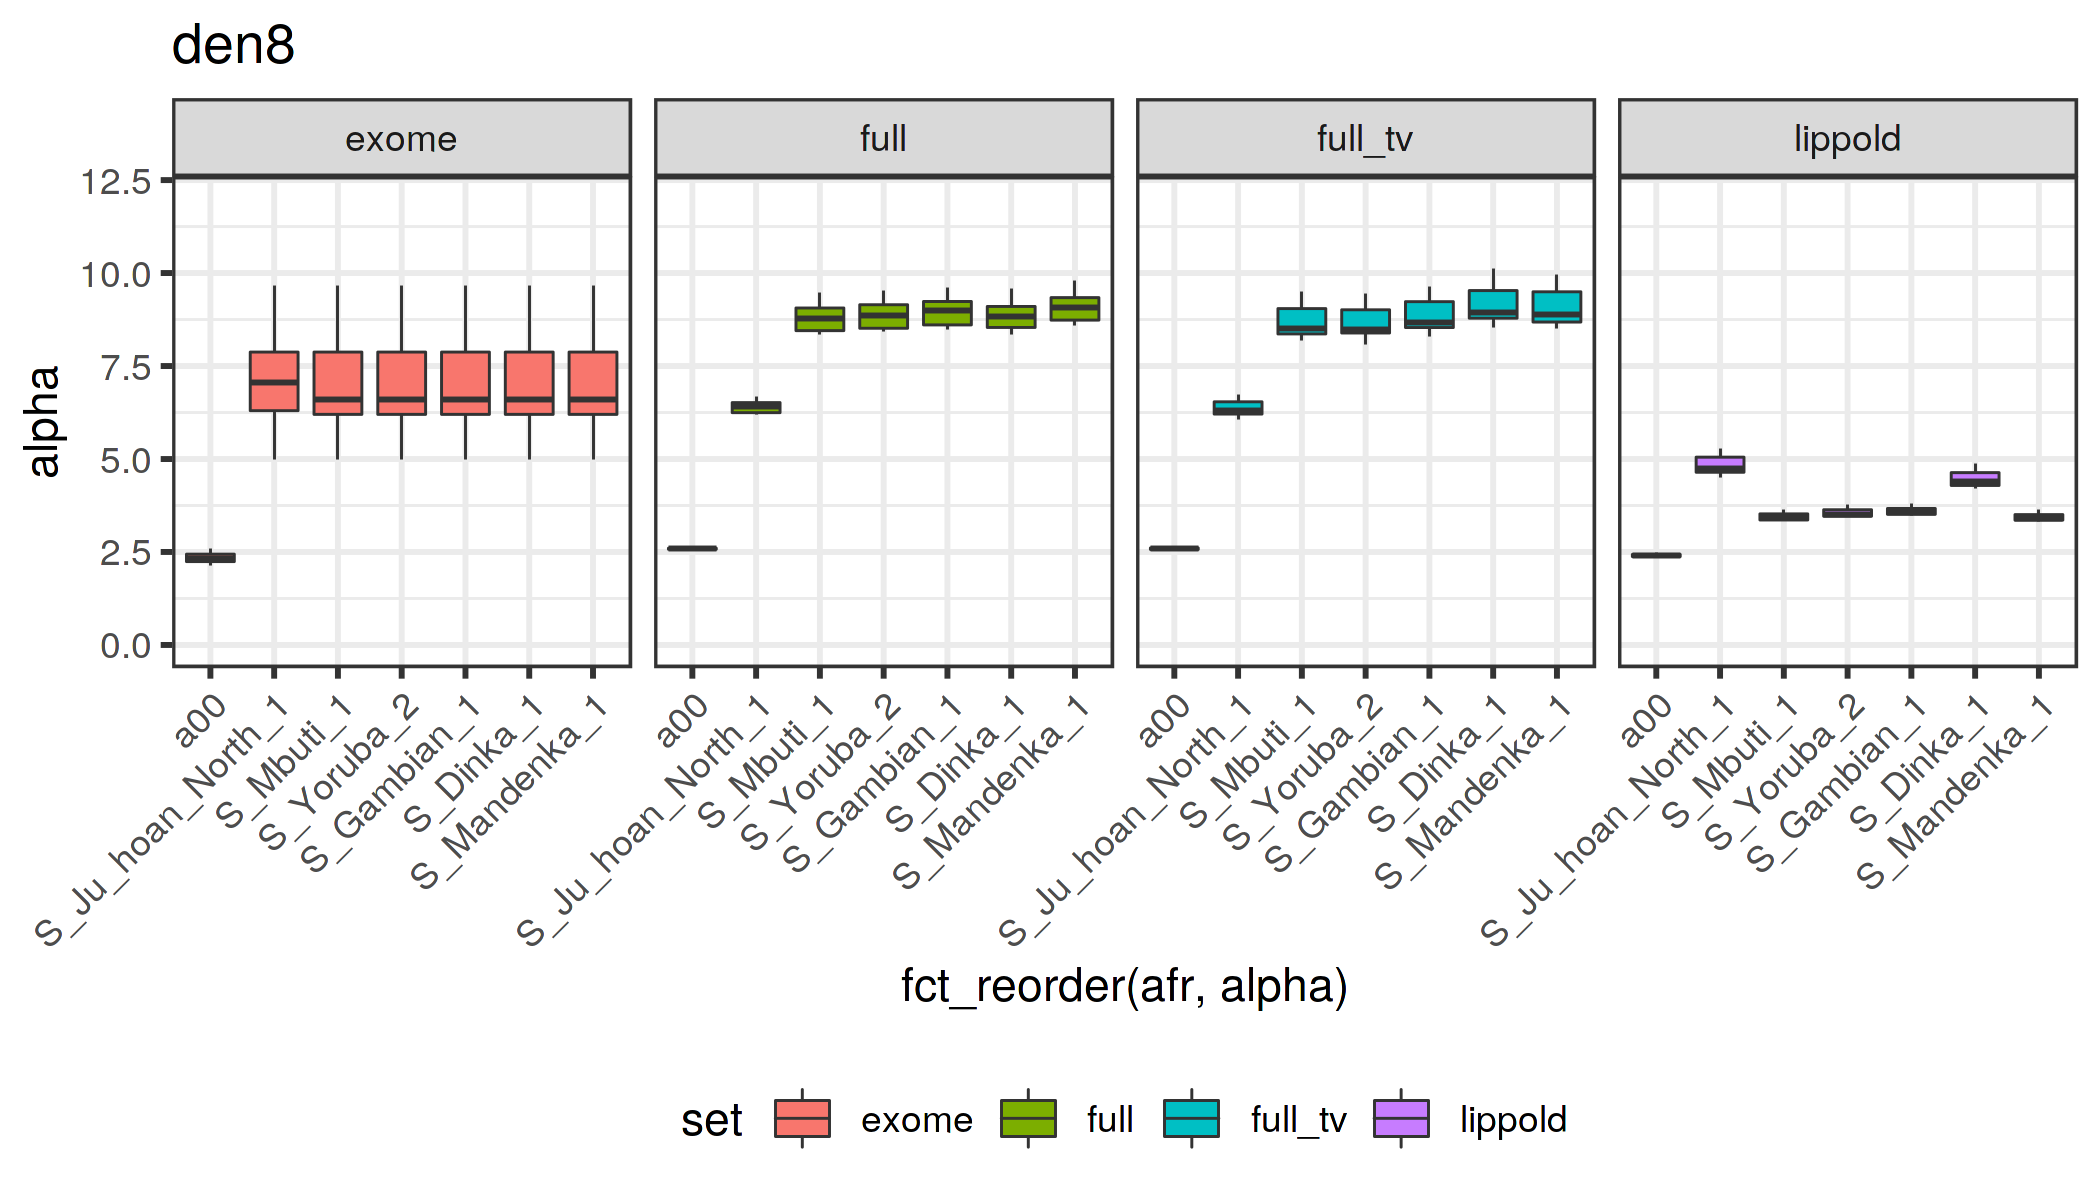

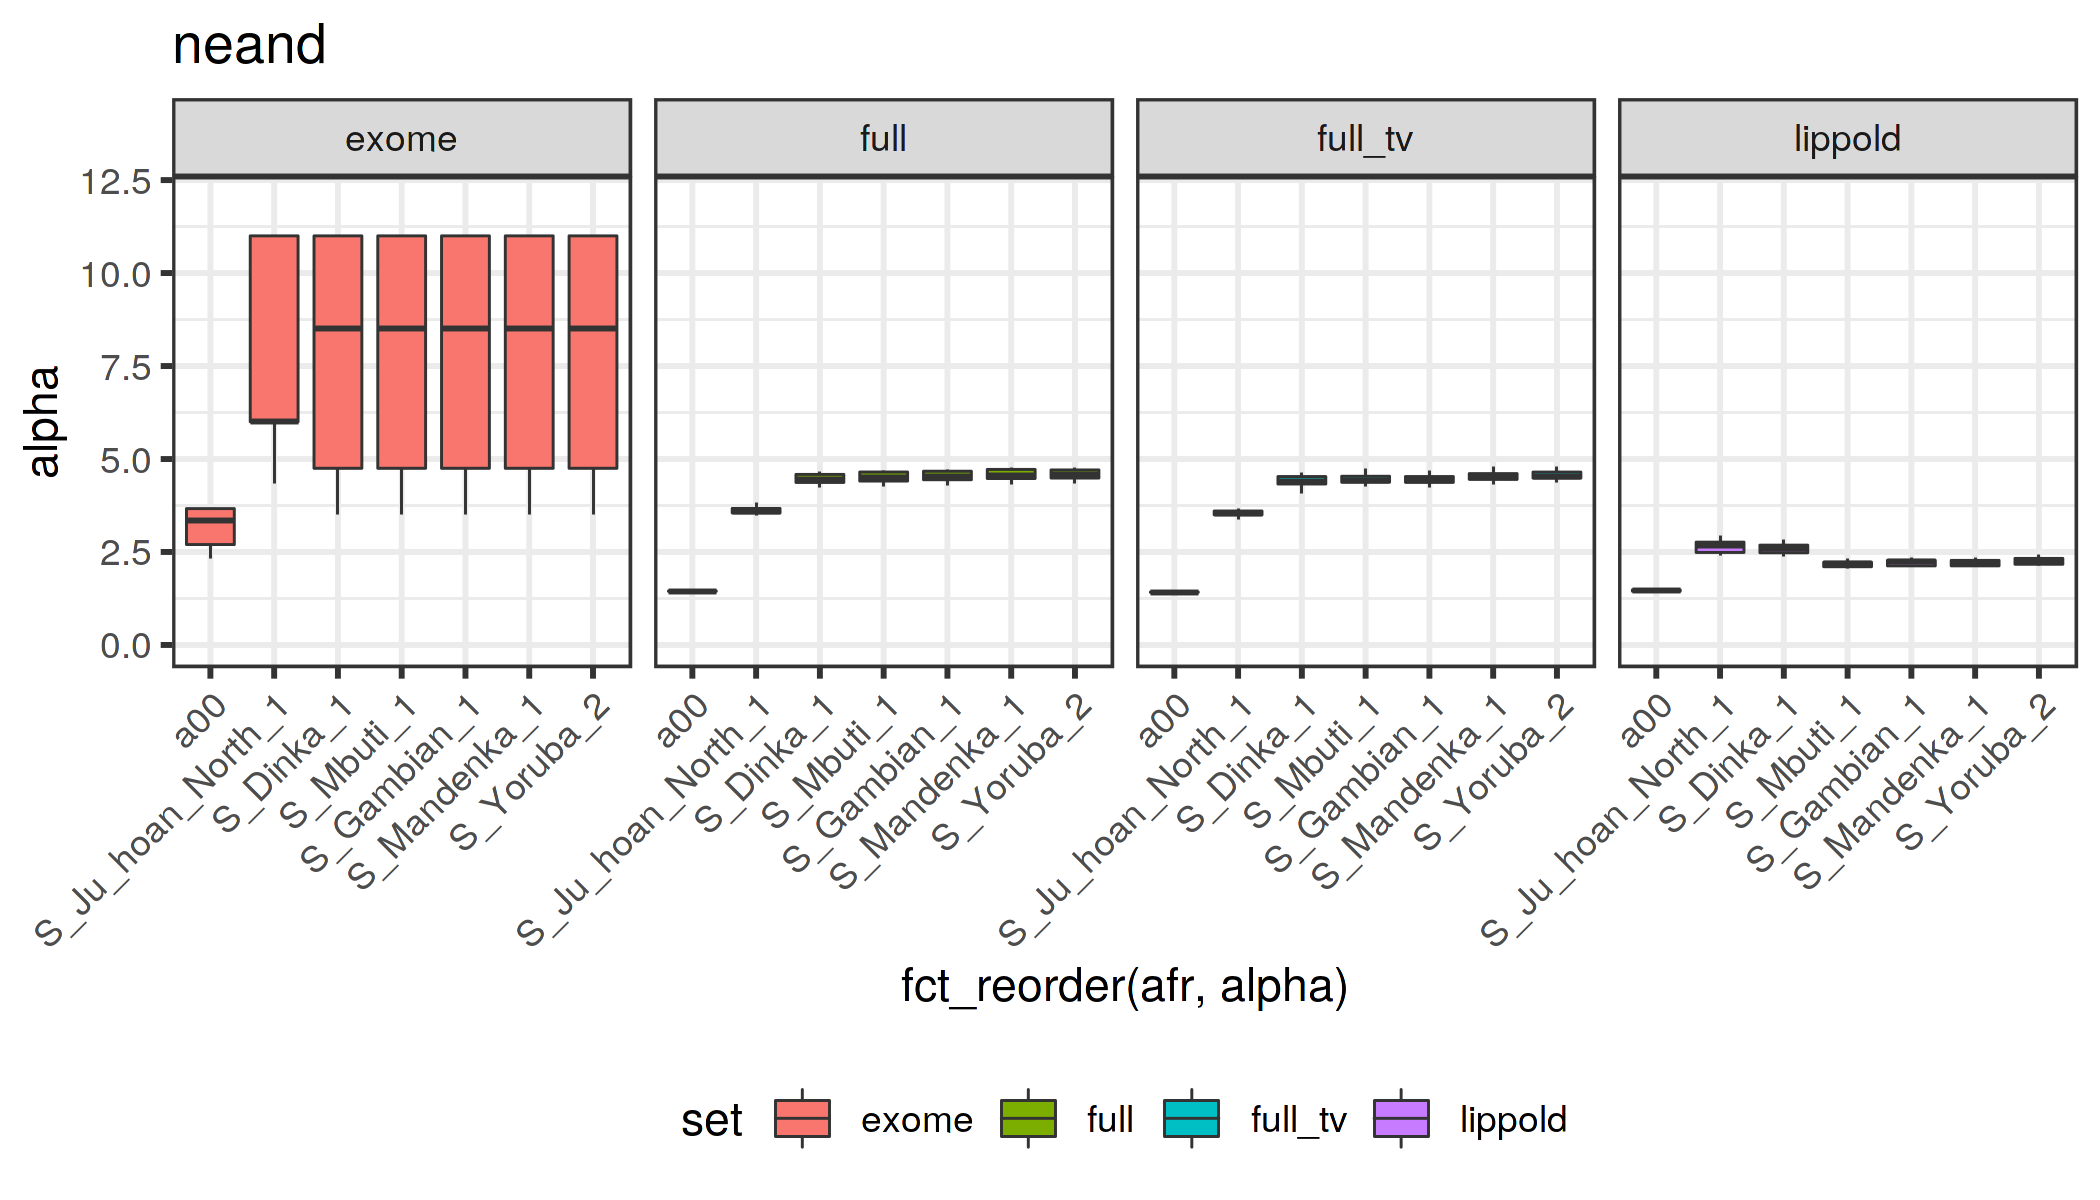

In [288]:
set_dim(7, 4)

tmrca %>% filter(arch == "den8") %>% 
unnest(counts_arch) %>%
ggplot(aes(fct_reorder(afr, alpha), alpha, fill = set)) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    facet_wrap(~ set, ncol = 4) +
    guides(fill = guide_legend("set")) +
    coord_cartesian(y = c(0, 12)) +
    theme_bw() +
    ggtitle("den8") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

tmrca %>% filter(arch == "neand") %>% 
unnest(counts_arch) %>%
ggplot(aes(fct_reorder(afr, alpha), alpha, fill = set)) +
    geom_boxplot(outlier.shape = NA, size = 0.25) +
    facet_wrap(~ set, ncol = 4) +
    guides(fill = guide_legend("set")) +
    coord_cartesian(y = c(0, 12)) +
    theme_bw() +
    ggtitle("neand") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

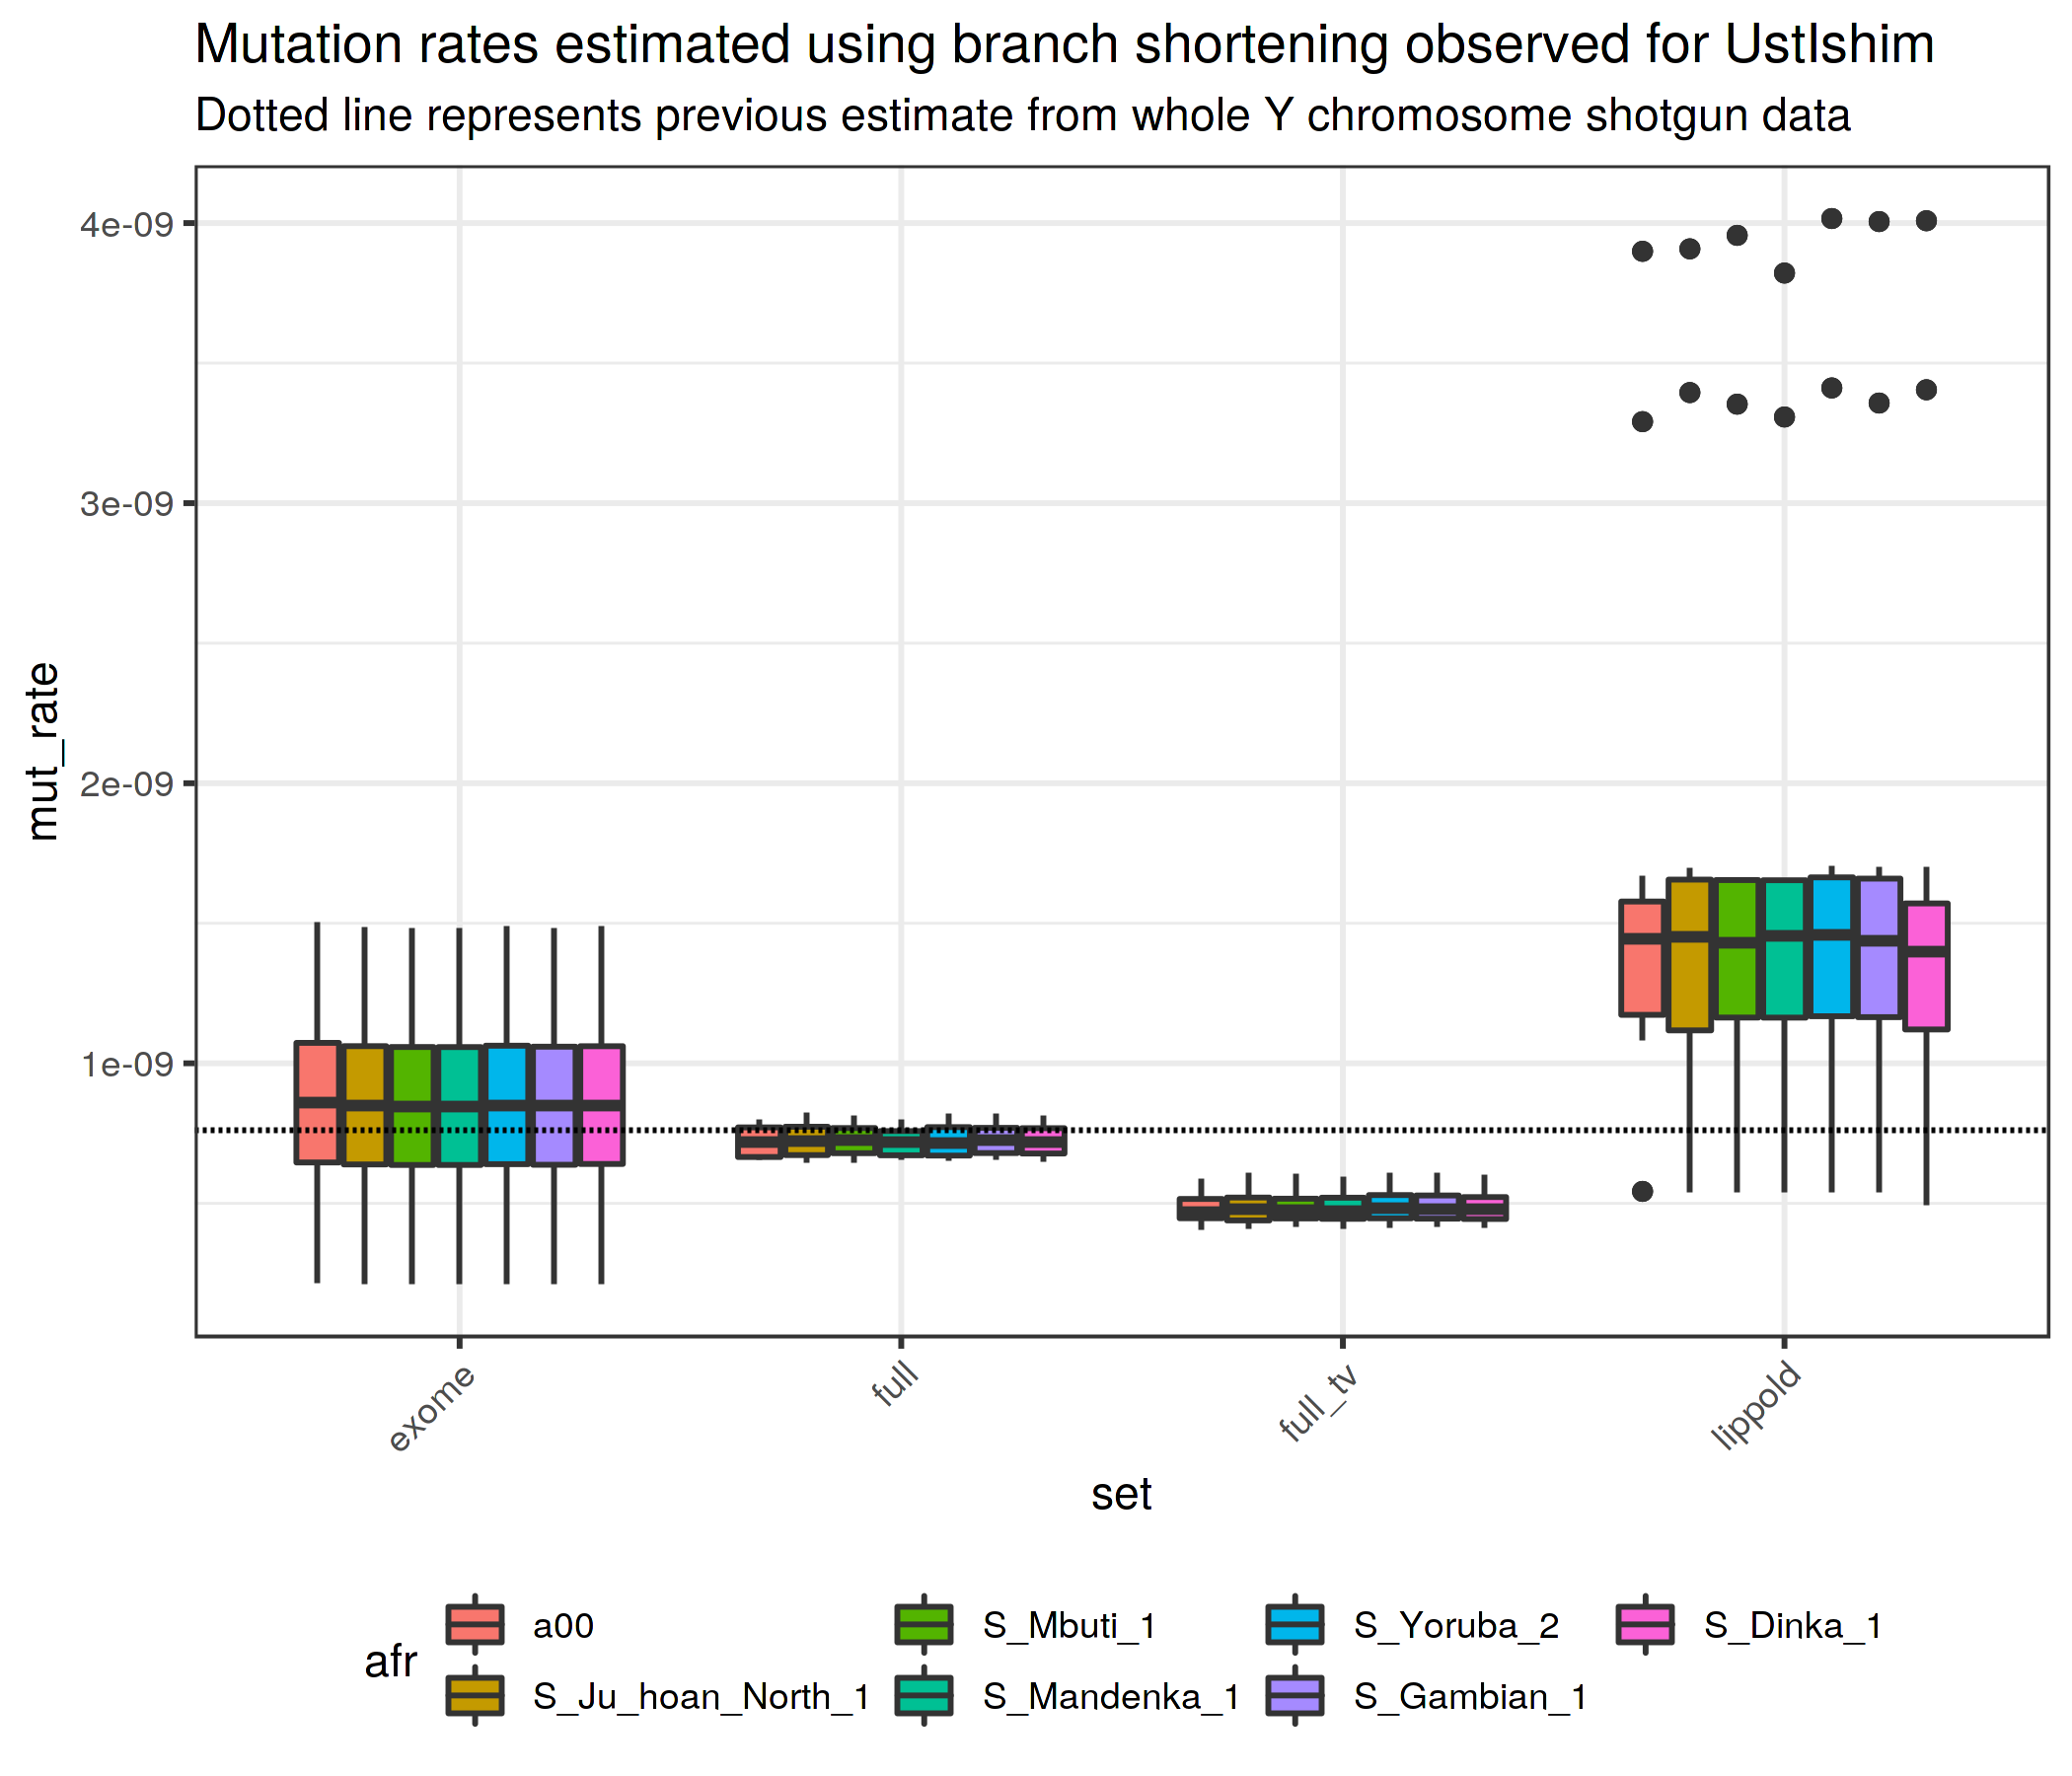

In [10]:
set_dim(7, 6)

tmrca %>%
ggplot(aes(set, mut_rate, fill = fct_reorder(afr, tmrca_afr, .desc = TRUE))) +
    geom_boxplot() +
    geom_hline(yintercept = 7.6e-10, linetype = 2, size = 0.5) +
    guides(fill = guide_legend("afr")) +
    theme_bw() +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45)) +
    ggtitle("Mutation rates estimated using branch shortening observed for UstIshim",
            "Dotted line represents previous estimate from whole Y chromosome shotgun data")

In [74]:
a = 8
d = 7
e = 5

In [100]:
a = 870
d = 457
e = 612

In [91]:
a = 164
d = 306
e = 396

In [101]:
a / (a + d + e)

[1] 0.4486849

In [102]:
p_ci <- binom.test(x = a, n = a + d + e, conf.level = 0.95)$conf.int
p_ci[1]
p_ci[2]

[1] 0.4263813

[1] 0.4711439

In [103]:
(alpha_ci <- (1 + p_ci)/(1 - p_ci))

[1] 2.486637 2.781747
attr(,"conf.level")
[1] 0.95

In [104]:
alpha_ci * 254000

[1] 631605.7 706563.8
attr(,"conf.level")
[1] 0.95

In [98]:
alpha_ci * 254000

[1] 353507.5 394860.8
attr(,"conf.level")
[1] 0.95

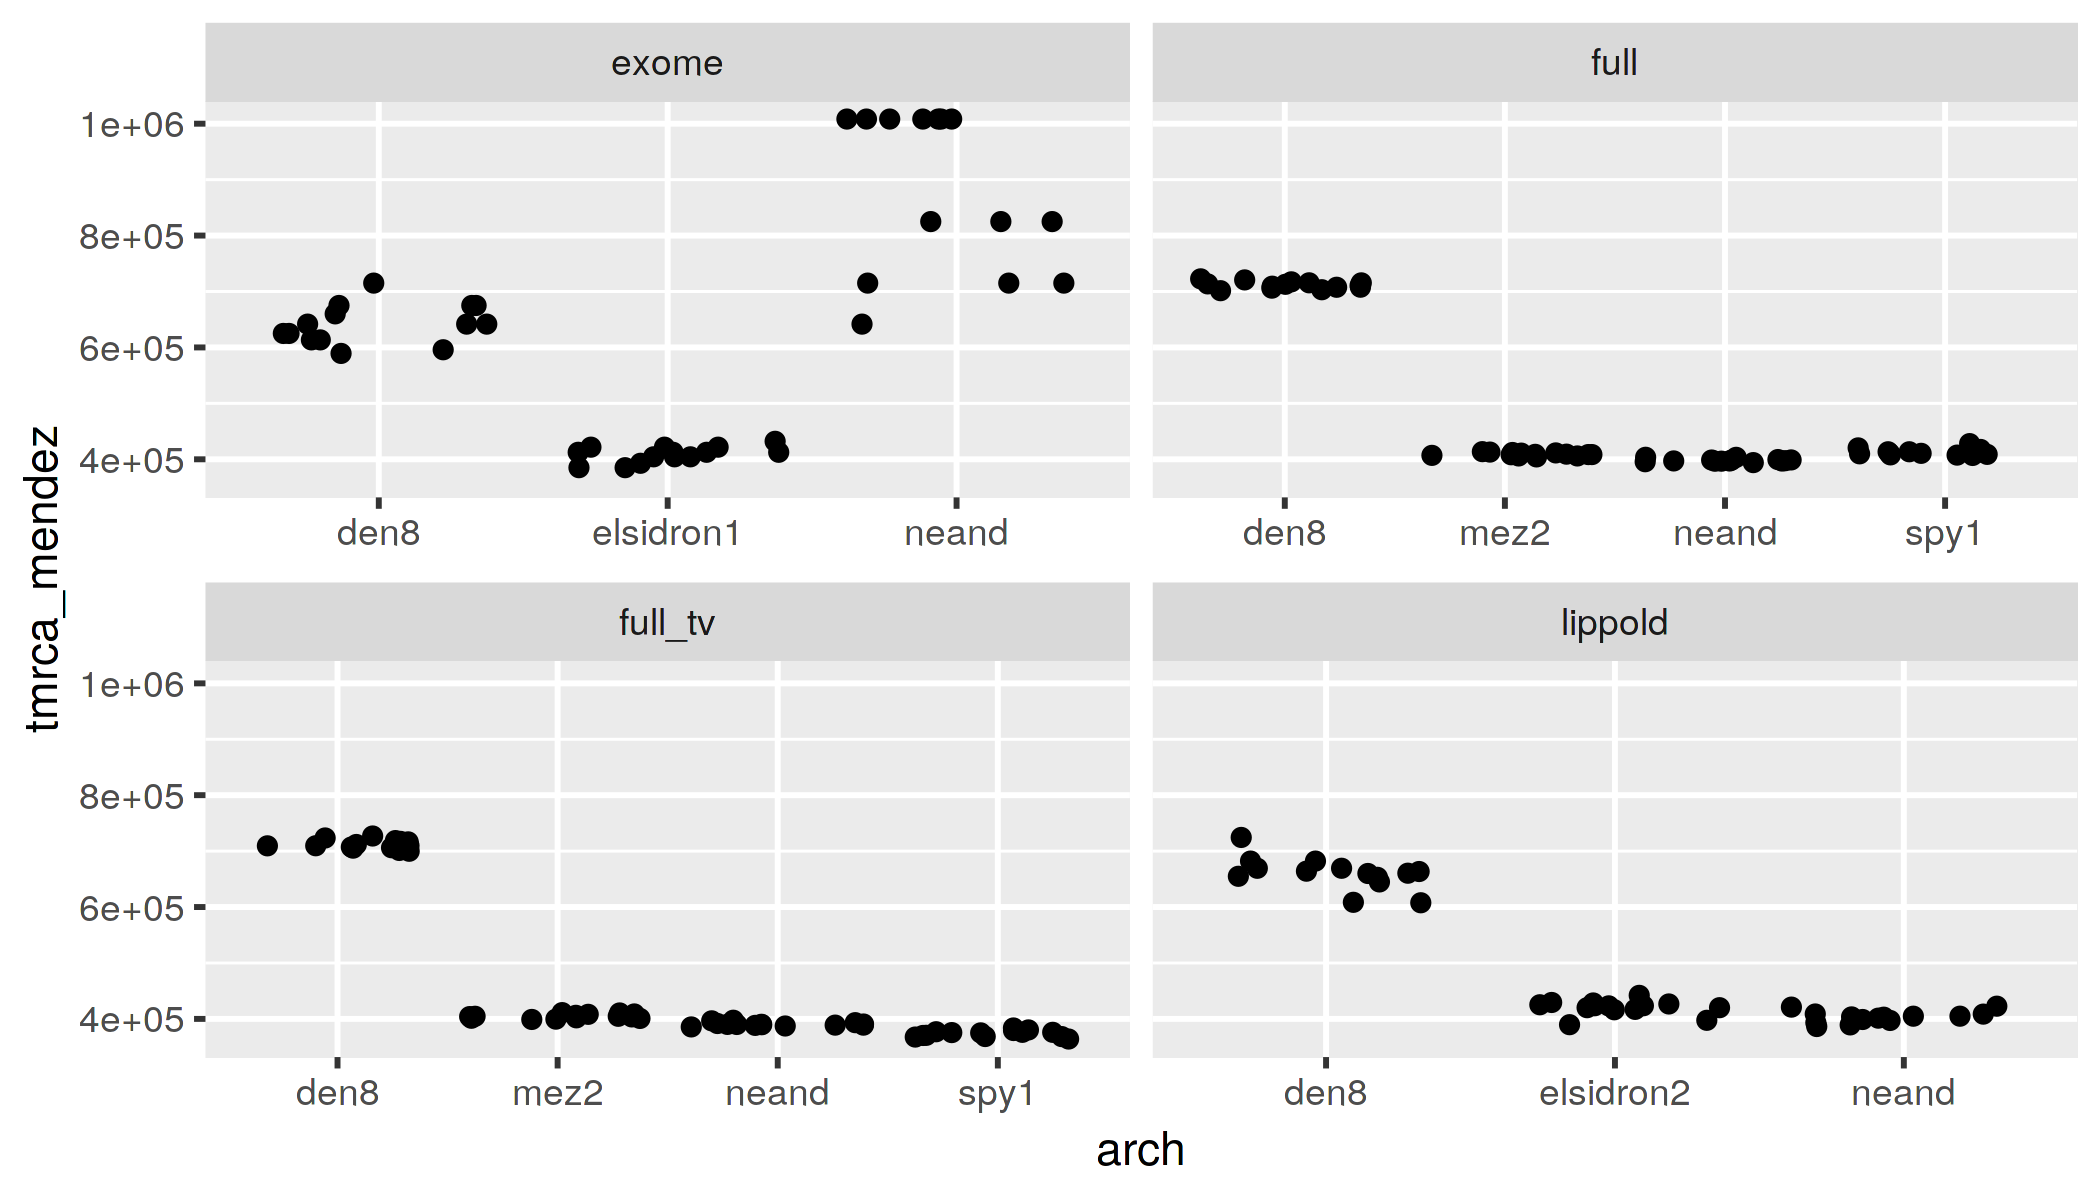

In [313]:
tmrca %>%
    filter(afr == "a00") %>%
    unnest(counts_arch) %>%
    ggplot(aes(arch, tmrca_mendez)) + geom_jitter() + facet_wrap(~ set, scales = "free_x")

In [323]:
tmrca %>%
    filter(afr == "a00", set == "exome") %>%
    unnest(counts_arch) %>%
    filter(arch %in% c("elsidron1", "neand", "den8")) %>% 
    arrange(arch)

arch,afr,ref,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,counts_afr,set,a,b,c,d,e,f,total
den8,a00,S_BedouinB_1,883636.4,2.454545,360000.0,360000,360000.0,4.291786e-10,675000.0,"14, 0, 0, 2, 0, 16, 103557",exome,8,1,0,6,5,11,35585
den8,a00,S_Turkish_1,469431.8,2.454545,191250.0,202500,180000.0,8.559766e-10,675000.0,"14, 0, 0, 4, 0, 16, 103845",exome,8,1,0,6,5,11,35661
den8,a00,S_French_1,289285.7,2.142857,135000.0,150000,120000.0,1.284856e-09,589285.7,"14, 0, 0, 6, 0, 16, 103773",exome,8,1,0,9,5,11,35645
den8,a00,S_Burmese_1,426634.6,2.230769,191250.0,202500,180000.0,8.599682e-10,613461.5,"14, 0, 0, 4, 0, 16, 103363",exome,8,1,0,8,5,11,35508
den8,a00,S_Thai_1,414375.0,2.166667,191250.0,202500,180000.0,8.662368e-10,595833.3,"14, 0, 0, 4, 0, 16, 102615",exome,7,1,0,7,5,8,35230
den8,a00,S_Finnish_2,1674000.0,2.400000,697500.0,675000,720000.0,2.143037e-10,660000.0,"14, 0, 0, 1, 0, 16, 103695",exome,7,1,0,5,5,11,35614
den8,a00,S_Sardinian_1,562500.0,2.272727,247500.0,255000,240000.0,6.459635e-10,625000.0,"14, 0, 0, 3, 0, 16, 103205",exome,7,1,0,6,5,11,35482
den8,a00,S_Han_2,455625.0,2.454545,185625.0,202500,168750.0,8.561415e-10,675000.0,"14, 0, 0, 4, 0, 15, 103825",exome,8,1,0,7,4,11,35664
den8,a00,S_Dai_2,351346.2,2.230769,157500.0,171000,144000.0,1.072843e-09,613461.5,"14, 0, 0, 5, 0, 16, 103567",exome,8,1,0,8,5,11,35572
den8,a00,S_Punjabi_1,367500.0,2.333333,157500.0,171000,144000.0,1.068952e-09,641666.7,"14, 0, 0, 5, 0, 16, 103944",exome,8,1,0,7,5,11,35669


In [300]:
tmrca %>%
    filter(set == "exome", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,540600.2,2.334297,229075.3,238178.6,219971.9,8.882523e-10,641931.6,7.714286,1,0,6.714286,4.928571,10.78571,35587.29
elsidron1,a00,340330.2,1.486555,229075.3,238178.6,219971.9,8.882523e-10,408802.5,3.785714,0,0,8.571429,7.000000,10.78571,51536.29
neand,a00,755942.6,3.200000,229075.3,238178.6,219971.9,8.882523e-10,880000.0,4.000000,0,0,1.857143,2.000000,12.00000,21797.14


In [118]:
tmrca %>%
    filter(set == "lippold", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,382188.5,2.401279,156768.1,187017.7,126518.6,1.627305e-09,660351.7,76.21429,1.92857143,2.428571,61.85714,47.50000,87.14286,313834.6
elsidron2,a00,241995.8,1.528074,156768.1,187017.7,126518.6,1.627305e-09,420220.2,47.71429,1.92857143,6.285714,110.14286,72.21429,93.14286,432438.4
neand,a00,230748.4,1.466009,156768.1,187017.7,126518.6,1.627305e-09,403152.6,16.92857,0.07142857,1.857143,37.35714,35.57143,59.50000,200768.4


In [121]:
tmrca %>%
    filter(set == "full", afr == "a00") %>%
    unnest(counts_arch) %>%
    group_by(arch, afr) %>%
    summarise_if(is.numeric, mean)

arch,afr,tmrca_arch,alpha,tmrca_afr,tmrca_ad,tmrca_f,mut_rate,tmrca_mendez,a,b,c,d,e,f,total
den8,a00,669697.6,2.588061,258735.8,279009,238462.6,7.228527e-10,711716.9,862.57143,33.714286,14.857143,480.00000,606.50000,1134.3571,3517347.0
mez2,a00,384877.1,1.487568,258735.8,279009,238462.6,7.228527e-10,409081.3,90.71429,13.928571,9.071429,176.00000,196.21429,538.0000,1222431.1
neand,a00,374532.4,1.447750,258735.8,279009,238462.6,7.228527e-10,398131.3,161.71429,19.428571,10.642857,328.78571,393.78571,764.8571,2364921.7
spy1,a00,388457.7,1.501758,258735.8,279009,238462.6,7.228527e-10,412983.3,36.07143,7.714286,0.500000,65.35714,78.57143,664.3571,568834.5
